In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [ ]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
num_steps_train_discriminator = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [ ]:

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/train-images-idx3-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/train-labels-idx1-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to input/data/MNIST/raw



# Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [ ]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [ ]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [ ]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [ ]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [ ]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)


In [ ]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [ ]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [ ]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

In [ ]:
torch.manual_seed(7777)

def generator_loss(generator_output):
    ############ YOUR CODE HERE ##########
     gen_disc_output = discriminator(generator_output)
     loss = criterion(gen_disc_output, label_real(len(gen_disc_output)))
     return loss
    
    
    ######################################
    
def discriminator_loss(discriminator_output_fake, discriminator_output_true):
    ############ YOUR CODE HERE ##########
    loss_fake = criterion(discriminator_output_fake, label_fake(len(discriminator_output_fake)))
    loss_real = criterion(discriminator_output_true, label_real(len(discriminator_output_true)))
    
    return loss_fake, loss_real
    
    ######################################

# Q. Write training loop

118it [06:09,  3.13s/it]


Epoch 1 of 100
Generator loss: 17.05011381, Discriminator loss: 0.30636959


118it [03:06,  1.58s/it]


Epoch 2 of 100
Generator loss: 12.52562395, Discriminator loss: 0.14086044


118it [03:06,  1.58s/it]


Epoch 3 of 100
Generator loss: 13.34170210, Discriminator loss: 0.02252793


118it [03:04,  1.57s/it]


Epoch 4 of 100
Generator loss: 14.75806598, Discriminator loss: 0.00686470


118it [03:07,  1.59s/it]


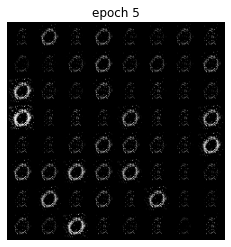

Epoch 5 of 100
Generator loss: 14.66563486, Discriminator loss: 0.05220039


118it [03:06,  1.58s/it]


Epoch 6 of 100
Generator loss: 14.33879128, Discriminator loss: 0.01463872


118it [03:08,  1.59s/it]


Epoch 7 of 100
Generator loss: 15.77907997, Discriminator loss: 0.01499593


118it [03:06,  1.58s/it]


Epoch 8 of 100
Generator loss: 16.35936714, Discriminator loss: 0.03345826


118it [03:03,  1.56s/it]


Epoch 9 of 100
Generator loss: 16.11400535, Discriminator loss: 0.04534243


118it [03:03,  1.55s/it]


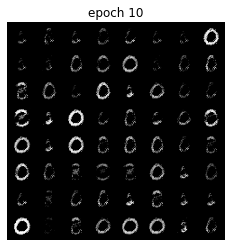

Epoch 10 of 100
Generator loss: 15.35865656, Discriminator loss: 0.03344485


118it [01:46,  1.10it/s]


Epoch 11 of 100
Generator loss: 13.38608930, Discriminator loss: 0.06706122


118it [01:46,  1.11it/s]


Epoch 12 of 100
Generator loss: 10.91321935, Discriminator loss: 0.13851022


118it [01:50,  1.07it/s]


Epoch 13 of 100
Generator loss: 11.01516618, Discriminator loss: 0.05746148


118it [01:51,  1.05it/s]


Epoch 14 of 100
Generator loss: 10.83198320, Discriminator loss: 0.06095472


118it [01:52,  1.05it/s]


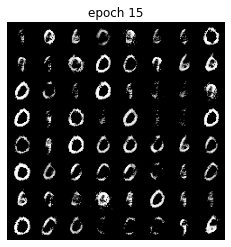

Epoch 15 of 100
Generator loss: 10.92268958, Discriminator loss: 0.06357504


118it [01:52,  1.05it/s]


Epoch 16 of 100
Generator loss: 10.95340906, Discriminator loss: 0.07220532


118it [01:51,  1.06it/s]


Epoch 17 of 100
Generator loss: 10.83508347, Discriminator loss: 0.07426205


118it [01:52,  1.05it/s]


Epoch 18 of 100
Generator loss: 9.44531239, Discriminator loss: 0.11819887


118it [01:50,  1.07it/s]


Epoch 19 of 100
Generator loss: 9.78878430, Discriminator loss: 0.10266739


118it [01:52,  1.05it/s]


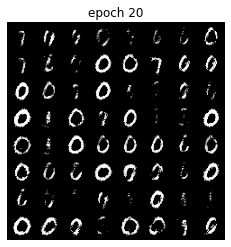

Epoch 20 of 100
Generator loss: 9.78826920, Discriminator loss: 0.10131108


118it [01:11,  1.65it/s]


Epoch 21 of 100
Generator loss: 8.64814181, Discriminator loss: 0.09050484


118it [01:10,  1.67it/s]


Epoch 22 of 100
Generator loss: 7.96901059, Discriminator loss: 0.12114982


118it [01:10,  1.67it/s]


Epoch 23 of 100
Generator loss: 7.89947654, Discriminator loss: 0.10711272


118it [01:12,  1.64it/s]


Epoch 24 of 100
Generator loss: 8.04059333, Discriminator loss: 0.10945831


118it [01:10,  1.68it/s]


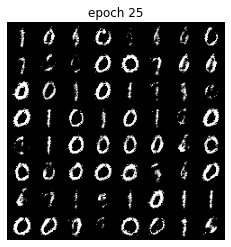

Epoch 25 of 100
Generator loss: 7.72839015, Discriminator loss: 0.13540549


118it [01:09,  1.71it/s]


Epoch 26 of 100
Generator loss: 7.48594146, Discriminator loss: 0.14694975


118it [01:09,  1.71it/s]


Epoch 27 of 100
Generator loss: 7.17268788, Discriminator loss: 0.15494360


118it [01:10,  1.68it/s]


Epoch 28 of 100
Generator loss: 7.03140072, Discriminator loss: 0.15619572


118it [01:09,  1.71it/s]


Epoch 29 of 100
Generator loss: 6.60831882, Discriminator loss: 0.19267835


118it [01:09,  1.70it/s]


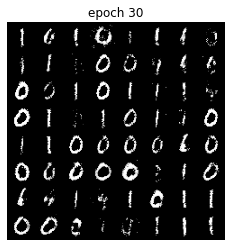

Epoch 30 of 100
Generator loss: 6.43236433, Discriminator loss: 0.19677361


118it [00:50,  2.32it/s]


Epoch 31 of 100
Generator loss: 5.67318041, Discriminator loss: 0.17536339


118it [00:52,  2.27it/s]


Epoch 32 of 100
Generator loss: 5.15832386, Discriminator loss: 0.21009310


118it [00:50,  2.32it/s]


Epoch 33 of 100
Generator loss: 4.96859654, Discriminator loss: 0.22139898


118it [00:50,  2.34it/s]


Epoch 34 of 100
Generator loss: 4.82243068, Discriminator loss: 0.21906995


118it [00:50,  2.32it/s]


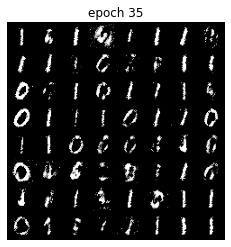

Epoch 35 of 100
Generator loss: 4.55347568, Discriminator loss: 0.23498908


118it [00:50,  2.32it/s]


Epoch 36 of 100
Generator loss: 4.70214595, Discriminator loss: 0.24206474


118it [00:51,  2.29it/s]


Epoch 37 of 100
Generator loss: 4.61917050, Discriminator loss: 0.26336038


118it [00:51,  2.29it/s]


Epoch 38 of 100
Generator loss: 4.37172874, Discriminator loss: 0.27907281


118it [00:50,  2.33it/s]


Epoch 39 of 100
Generator loss: 4.25550862, Discriminator loss: 0.29559798


118it [00:50,  2.35it/s]


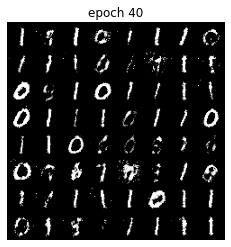

Epoch 40 of 100
Generator loss: 4.13246146, Discriminator loss: 0.28808312


118it [00:51,  2.31it/s]


Epoch 41 of 100
Generator loss: 3.74827871, Discriminator loss: 0.32855517


118it [00:51,  2.30it/s]


Epoch 42 of 100
Generator loss: 3.72939268, Discriminator loss: 0.33901146


118it [00:51,  2.29it/s]


Epoch 43 of 100
Generator loss: 3.73700864, Discriminator loss: 0.34387538


118it [00:50,  2.33it/s]


Epoch 44 of 100
Generator loss: 3.72166407, Discriminator loss: 0.34534858


118it [00:49,  2.39it/s]


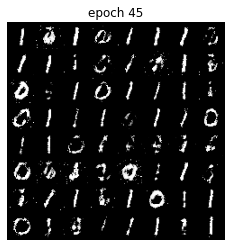

Epoch 45 of 100
Generator loss: 3.48451383, Discriminator loss: 0.37010738


118it [00:48,  2.41it/s]


Epoch 46 of 100
Generator loss: 3.44706315, Discriminator loss: 0.39006027


118it [00:49,  2.38it/s]


Epoch 47 of 100
Generator loss: 3.46023013, Discriminator loss: 0.38988295


118it [00:50,  2.35it/s]


Epoch 48 of 100
Generator loss: 3.32947940, Discriminator loss: 0.39669274


118it [00:50,  2.33it/s]


Epoch 49 of 100
Generator loss: 3.35930119, Discriminator loss: 0.40957392


118it [00:50,  2.32it/s]


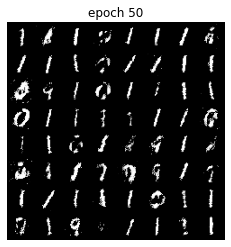

Epoch 50 of 100
Generator loss: 3.34614860, Discriminator loss: 0.41434829


118it [00:50,  2.33it/s]


Epoch 51 of 100
Generator loss: 3.20088962, Discriminator loss: 0.44138812


118it [00:51,  2.31it/s]


Epoch 52 of 100
Generator loss: 3.05846788, Discriminator loss: 0.42076641


118it [00:52,  2.27it/s]


Epoch 53 of 100
Generator loss: 3.10370637, Discriminator loss: 0.43887793


118it [00:50,  2.34it/s]


Epoch 54 of 100
Generator loss: 3.08994433, Discriminator loss: 0.47748423


118it [00:51,  2.29it/s]


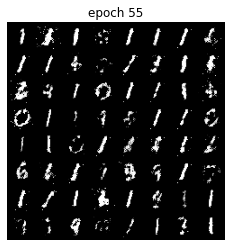

Epoch 55 of 100
Generator loss: 2.96253292, Discriminator loss: 0.48825515


118it [00:50,  2.32it/s]


Epoch 56 of 100
Generator loss: 2.88075851, Discriminator loss: 0.51214064


118it [00:50,  2.32it/s]


Epoch 57 of 100
Generator loss: 2.74154092, Discriminator loss: 0.53263315


118it [00:52,  2.25it/s]


Epoch 58 of 100
Generator loss: 2.85061648, Discriminator loss: 0.51472001


118it [00:50,  2.34it/s]


Epoch 59 of 100
Generator loss: 2.83333295, Discriminator loss: 0.50876344


118it [00:50,  2.32it/s]


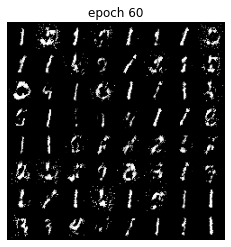

Epoch 60 of 100
Generator loss: 2.84404151, Discriminator loss: 0.52856821


118it [00:50,  2.32it/s]


Epoch 61 of 100
Generator loss: 2.77515676, Discriminator loss: 0.53370702


118it [00:50,  2.32it/s]


Epoch 62 of 100
Generator loss: 2.76343044, Discriminator loss: 0.53958618


118it [00:51,  2.29it/s]


Epoch 63 of 100
Generator loss: 2.58676468, Discriminator loss: 0.54843257


118it [00:51,  2.30it/s]


Epoch 64 of 100
Generator loss: 2.74525546, Discriminator loss: 0.52791461


118it [00:49,  2.36it/s]


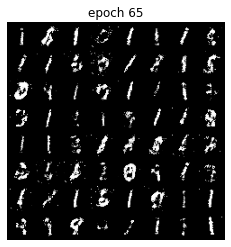

Epoch 65 of 100
Generator loss: 2.79084503, Discriminator loss: 0.54164784


118it [00:50,  2.33it/s]


Epoch 66 of 100
Generator loss: 2.70334820, Discriminator loss: 0.54422088


118it [00:50,  2.33it/s]


Epoch 67 of 100
Generator loss: 2.66399724, Discriminator loss: 0.53166883


118it [00:51,  2.30it/s]


Epoch 68 of 100
Generator loss: 2.60762008, Discriminator loss: 0.52818205


118it [00:51,  2.30it/s]


Epoch 69 of 100
Generator loss: 2.51423910, Discriminator loss: 0.57981750


118it [00:50,  2.33it/s]


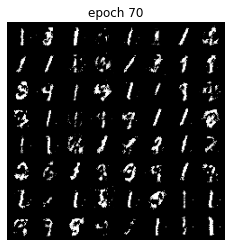

Epoch 70 of 100
Generator loss: 2.53744726, Discriminator loss: 0.57904672


118it [00:50,  2.32it/s]


Epoch 71 of 100
Generator loss: 2.63073822, Discriminator loss: 0.55949221


118it [00:51,  2.27it/s]


Epoch 72 of 100
Generator loss: 2.51873561, Discriminator loss: 0.60067255


118it [00:52,  2.25it/s]


Epoch 73 of 100
Generator loss: 2.55925226, Discriminator loss: 0.56703278


118it [00:51,  2.30it/s]


Epoch 74 of 100
Generator loss: 2.65845160, Discriminator loss: 0.59039042


118it [00:51,  2.31it/s]


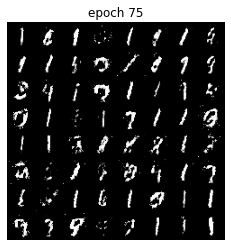

Epoch 75 of 100
Generator loss: 2.44319000, Discriminator loss: 0.59147425


118it [00:51,  2.31it/s]


Epoch 76 of 100
Generator loss: 2.48777218, Discriminator loss: 0.60082462


118it [00:51,  2.31it/s]


Epoch 77 of 100
Generator loss: 2.44241241, Discriminator loss: 0.62242435


118it [00:51,  2.31it/s]


Epoch 78 of 100
Generator loss: 2.40686830, Discriminator loss: 0.62392236


118it [00:51,  2.29it/s]


Epoch 79 of 100
Generator loss: 2.29596404, Discriminator loss: 0.65747488


118it [00:50,  2.32it/s]


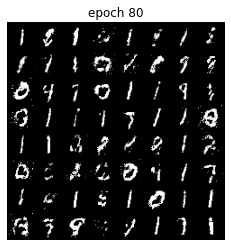

Epoch 80 of 100
Generator loss: 2.27837545, Discriminator loss: 0.67891772


118it [00:51,  2.31it/s]


Epoch 81 of 100
Generator loss: 2.28959152, Discriminator loss: 0.69431458


118it [00:51,  2.31it/s]


Epoch 82 of 100
Generator loss: 2.24549810, Discriminator loss: 0.68581368


118it [00:51,  2.30it/s]


Epoch 83 of 100
Generator loss: 2.27311744, Discriminator loss: 0.67788589


118it [00:51,  2.28it/s]


Epoch 84 of 100
Generator loss: 2.23738048, Discriminator loss: 0.71130720


118it [00:51,  2.31it/s]


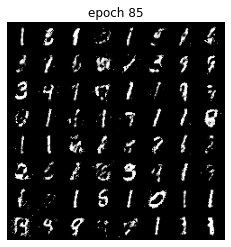

Epoch 85 of 100
Generator loss: 2.09466612, Discriminator loss: 0.73946251


118it [00:50,  2.32it/s]


Epoch 86 of 100
Generator loss: 2.21239261, Discriminator loss: 0.71260779


118it [00:50,  2.32it/s]


Epoch 87 of 100
Generator loss: 2.26012012, Discriminator loss: 0.69080400


118it [00:50,  2.34it/s]


Epoch 88 of 100
Generator loss: 2.11354797, Discriminator loss: 0.71208180


118it [00:50,  2.33it/s]


Epoch 89 of 100
Generator loss: 2.16421155, Discriminator loss: 0.70048771


118it [00:50,  2.33it/s]


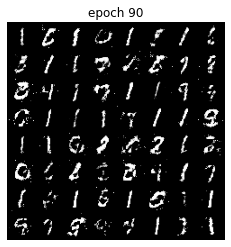

Epoch 90 of 100
Generator loss: 2.16069306, Discriminator loss: 0.71784863


118it [00:51,  2.30it/s]


Epoch 91 of 100
Generator loss: 2.12628070, Discriminator loss: 0.72996165


118it [00:50,  2.33it/s]


Epoch 92 of 100
Generator loss: 2.14404591, Discriminator loss: 0.72502976


118it [00:49,  2.37it/s]


Epoch 93 of 100
Generator loss: 2.00570960, Discriminator loss: 0.76246269


118it [00:51,  2.28it/s]


Epoch 94 of 100
Generator loss: 1.98085317, Discriminator loss: 0.77275723


118it [00:51,  2.29it/s]


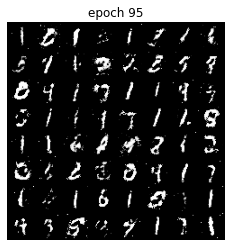

Epoch 95 of 100
Generator loss: 2.08900968, Discriminator loss: 0.74761866


118it [00:50,  2.32it/s]


Epoch 96 of 100
Generator loss: 2.03506120, Discriminator loss: 0.76691918


118it [00:50,  2.32it/s]


Epoch 97 of 100
Generator loss: 1.98227384, Discriminator loss: 0.76647452


118it [00:49,  2.38it/s]


Epoch 98 of 100
Generator loss: 2.01703534, Discriminator loss: 0.76373032


118it [00:51,  2.30it/s]


Epoch 99 of 100
Generator loss: 1.92850062, Discriminator loss: 0.80400195


118it [00:52,  2.26it/s]


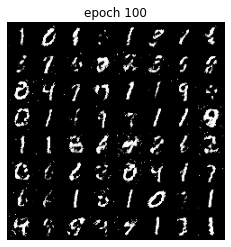

Epoch 100 of 100
Generator loss: 1.87810030, Discriminator loss: 0.82396384


In [ ]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        ############ YOUR CODE HERE ########## 

        #get the input to device
        data[0].to(device)

        # optimize discriminator
        loss_d_total = 0.0
        if epoch == 0:
          n = 16
        elif epoch < 10:
          n = 8
        elif epoch < 20:
          n = 4
        elif epoch < 30:
          n = 2
        else:
          n = num_steps_train_discriminator
        for _ in range(n):
          generator_output = generator(create_noise(len(data[0]), nz)).detach() 
          optim_d.zero_grad()
          
          # .detach() to ensure not part of the graph

          #get the preds from discriminator on fake and true data
          gen_disc_output = discriminator(generator_output)
          true_data_output = discriminator(data[0])

          #optimize the loss
          
          disc_loss_fake, disc_loss_real  = discriminator_loss(gen_disc_output, true_data_output) #between fake and true images
          disc_loss_fake.backward()
          disc_loss_real.backward()
          optim_d.step()

          #increase counter
          loss_d_total += (disc_loss_fake+disc_loss_real).detach().cpu().numpy()
    
        # optimize generator
        optim_g.zero_grad()
        generator_output = generator(create_noise(len(data[0]), nz))
        gen_loss = generator_loss(generator_output)
        gen_loss.backward()
        optim_g.step()

        loss_g += gen_loss.detach().cpu().numpy()
        loss_d += loss_d_total / num_steps_train_discriminator
        ######################################
    
    
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
    
    # visualize generated images
    if (epoch + 1) % 5 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()
    
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [ ]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [ ]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

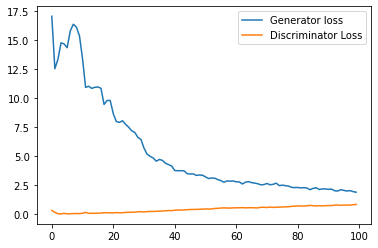

In [ ]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')